# Creating a Sentiment Analysis Web App
## Using PyTorch and SageMaker

_Deep Learning Nanodegree Program | Deployment_

---

Now that we have a basic understanding of how SageMaker works we will try to use it to construct a complete project from end to end. Our goal will be to have a simple web page which a user can use to enter a movie review. The web page will then send the review off to our deployed model which will predict the sentiment of the entered review.

## Instructions

Some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this notebook. You will not need to modify the included code beyond what is requested. Sections that begin with '**TODO**' in the header indicate that you need to complete or implement some portion within them. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `# TODO: ...` comment. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions for you to answer which relate to the task and your implementation. Each section where you will answer a question is preceded by a '**Question:**' header. Carefully read each question and provide your answer below the '**Answer:**' header by editing the Markdown cell.

> **Note**: Code and Markdown cells can be executed using the **Shift+Enter** keyboard shortcut. In addition, a cell can be edited by typically clicking it (double-click for Markdown cells) or by pressing **Enter** while it is highlighted.

## General Outline

Recall the general outline for SageMaker projects using a notebook instance.

1. Download or otherwise retrieve the data.
2. Process / Prepare the data.
3. Upload the processed data to S3.
4. Train a chosen model.
5. Test the trained model (typically using a batch transform job).
6. Deploy the trained model.
7. Use the deployed model.

For this project, you will be following the steps in the general outline with some modifications. 

First, you will not be testing the model in its own step. You will still be testing the model, however, you will do it by deploying your model and then using the deployed model by sending the test data to it. One of the reasons for doing this is so that you can make sure that your deployed model is working correctly before moving forward.

In addition, you will deploy and use your trained model a second time. In the second iteration you will customize the way that your trained model is deployed by including some of your own code. In addition, your newly deployed model will be used in the sentiment analysis web app.

In [1]:
# Make sure that we use SageMaker 1.x
!pip install sagemaker==1.72.0

     |████████████████████████████████| 297 kB 12.3 MB/s eta 0:00:01
  Created wheel for sagemaker: filename=sagemaker-1.72.0-py2.py3-none-any.whl size=386358 sha256=6002f1c6faae277a4b30c5d758624b23056beab608424ca144b1f228bb40e931
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c3/58/70/85faf4437568bfaa4c419937569ba1fe54d44c5db42406bbd7
Successfully built sagemaker
  Attempting uninstall: smdebug-rulesconfig
    Found existing installation: smdebug-rulesconfig 1.0.1
    Uninstalling smdebug-rulesconfig-1.0.1:
      Successfully uninstalled smdebug-rulesconfig-1.0.1
  Attempting uninstall: sagemaker
    Found existing installation: sagemaker 2.25.2
    Uninstalling sagemaker-2.25.2:
      Successfully uninstalled sagemaker-2.25.2


## Step 1: Downloading the data

As in the XGBoost in SageMaker notebook, we will be using the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/)

> Maas, Andrew L., et al. [Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas/data/sentiment/). In _Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies_. Association for Computational Linguistics, 2011.

In [2]:
%mkdir ../data
!wget -O ../data/aclImdb_v1.tar.gz http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -zxf ../data/aclImdb_v1.tar.gz -C ../data

mkdir: cannot create directory ‘../data’: File exists
--2021-03-07 18:36:45--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘../data/aclImdb_v1.tar.gz’

../data/aclImdb_v1. 100%[===================>]  80.23M  22.7MB/s    in 5.1s    

2021-03-07 18:36:51 (15.6 MB/s) - ‘../data/aclImdb_v1.tar.gz’ saved [84125825/84125825]



## Step 2: Preparing and Processing the data

Also, as in the XGBoost notebook, we will be doing some initial data processing. The first few steps are the same as in the XGBoost example. To begin with, we will read in each of the reviews and combine them into a single input structure. Then, we will split the dataset into a training set and a testing set.

In [4]:
import os
import glob

def read_imdb_data(data_dir='../data/aclImdb'):
    data = {}
    labels = {}
    
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}
        
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    # Here we represent a positive review by '1' and a negative review by '0'
                    labels[data_type][sentiment].append(1 if sentiment == 'pos' else 0)
                    
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
                
    return data, labels

In [5]:
data, labels = read_imdb_data()
print("IMDB reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
            len(data['train']['pos']), len(data['train']['neg']),
            len(data['test']['pos']), len(data['test']['neg'])))

IMDB reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


Now that we've read the raw training and testing data from the downloaded dataset, we will combine the positive and negative reviews and shuffle the resulting records.

In [6]:
from sklearn.utils import shuffle

def prepare_imdb_data(data, labels):
    """Prepare training and test sets from IMDb movie reviews."""
    
    #Combine positive and negative reviews and labels
    data_train = data['train']['pos'] + data['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']
    
    #Shuffle reviews and corresponding labels within training and test sets
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test

In [7]:
train_X, test_X, train_y, test_y = prepare_imdb_data(data, labels)
print("IMDb reviews (combined): train = {}, test = {}".format(len(train_X), len(test_X)))

IMDb reviews (combined): train = 25000, test = 25000


Now that we have our training and testing sets unified and prepared, we should do a quick check and see an example of the data our model will be trained on. This is generally a good idea as it allows you to see how each of the further processing steps affects the reviews and it also ensures that the data has been loaded correctly.

In [8]:
print(train_X[100])
print(train_y[100])

Personally, I enjoyed Cut thouroughly. It was the first time I've seen a theatrically release Australian slasher flick. A genre normally restricted to the mainstream hollywood films.<br /><br />With all the usual cooky comedies and dramas coming out of Australia I loved being able to see a homegrown horror movie that wasn't a rip off of anything. I didn't even think it was really a spoof of other movies. It was a supernaturally theme horror like Nightmare on Elm Street, not Scream or I know What You Did Last Summer and therefore there was more of a suspension of disbelief. I think it's about time Australian films tried to get more into the mainstream genres.<br /><br />Cut was original, scary enough and ultimately just a bit of fun. I'd give it seven out of ten and wouldn't treat it as anything serious. It did what I expected it to do, entertain and scare me enough times to be satisfying. I enjoyed it.
1


The first step in processing the reviews is to make sure that any html tags that appear should be removed. In addition we wish to tokenize our input, that way words such as *entertained* and *entertaining* are considered the same with regard to sentiment analysis.

In [10]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

import re
from bs4 import BeautifulSoup

def review_to_words(review):
    nltk.download("stopwords", quiet=True)
    stemmer = PorterStemmer()
    
    text = BeautifulSoup(review, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem
    
    return words

The `review_to_words` method defined above uses `BeautifulSoup` to remove any html tags that appear and uses the `nltk` package to tokenize the reviews. As a check to ensure we know how everything is working, try applying `review_to_words` to one of the reviews in the training set.

In [11]:
# TODO: Apply review_to_words to a review (train_X[100] or any other review)
words = review_to_words(train_X[4999])
print(words)

['plot', 'predict', 'fight', 'gun', 'get', 'old', 'defin', 'movi', 'look', 'low', 'iq', 'realli', 'care', 'real', 'movi', 'would', 'endulg', 'true', 'art', 'movi', 'like', 'clerk', 'someth', 'mari', 'el', 'mariachi', 'la', 'taqueria']


**Question:** Above we mentioned that `review_to_words` method removes html formatting and allows us to tokenize the words found in a review, for example, converting *entertained* and *entertaining* into *entertain* so that they are treated as though they are the same word. What else, if anything, does this method do to the input?

**Answer: 

Ths method 'review_to_words' removes punctuation marks and also some last letters of some of the words. It also removes stop words.

The method below applies the review_to_words method to each of the reviews in the training and testing datasets. In addition it caches the results. This is because performing this processing step can take a long time. This way if you are unable to complete the notebook in the current session, you can come back without needing to process the data a second time.

The method below applies the `review_to_words` method to each of the reviews in the training and testing datasets. In addition it caches the results. This is because performing this processing step can take a long time. This way if you are unable to complete the notebook in the current session, you can come back without needing to process the data a second time.

In [12]:
import pickle

cache_dir = os.path.join("../cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        #words_train = list(map(review_to_words, data_train))
        #words_test = list(map(review_to_words, data_test))
        words_train = [review_to_words(review) for review in data_train]
        words_test = [review_to_words(review) for review in data_test]
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test

In [13]:
# Preprocess data
train_X, test_X, train_y, test_y = preprocess_data(train_X, test_X, train_y, test_y)

Read preprocessed data from cache file: preprocessed_data.pkl


## Transform the data

In the XGBoost notebook we transformed the data from its word representation to a bag-of-words feature representation. For the model we are going to construct in this notebook we will construct a feature representation which is very similar. To start, we will represent each word as an integer. Of course, some of the words that appear in the reviews occur very infrequently and so likely don't contain much information for the purposes of sentiment analysis. The way we will deal with this problem is that we will fix the size of our working vocabulary and we will only include the words that appear most frequently. We will then combine all of the infrequent words into a single category and, in our case, we will label it as `1`.

Since we will be using a recurrent neural network, it will be convenient if the length of each review is the same. To do this, we will fix a size for our reviews and then pad short reviews with the category 'no word' (which we will label `0`) and truncate long reviews.

### (TODO) Create a word dictionary

To begin with, we need to construct a way to map words that appear in the reviews to integers. Here we fix the size of our vocabulary (including the 'no word' and 'infrequent' categories) to be `5000` but you may wish to change this to see how it affects the model.

> **TODO:** Complete the implementation for the `build_dict()` method below. Note that even though the vocab_size is set to `5000`, we only want to construct a mapping for the most frequently appearing `4998` words. This is because we want to reserve the special labels `0` for 'no word' and `1` for 'infrequent word'.

In [14]:
import numpy as np

def build_dict(data, vocab_size = 5000):
    """Construct and return a dictionary mapping each of the most frequently appearing words to a unique integer."""
    
    # TODO: Determine how often each word appears in `data`. Note that `data` is a list of sentences and that a
    #       sentence is a list of words.
    
    word_count = {} # A dict storing the words that appear in the reviews along with how often they occur
    
    for words in data:
        for word in words:
            if word in word_count:
                word_count[word] += 1
            else:
                word_count[word] = 1
    
    # TODO: Sort the words found in `data` so that sorted_words[0] is the most frequently appearing word and
    #       sorted_words[-1] is the least frequently appearing word.
    
    sorted_words = [item[0] for item in sorted(word_count.items(), key=lambda x: x[1], reverse=True)]
    
    word_dict = {} # This is what we are building, a dictionary that translates words into integers
    for idx, word in enumerate(sorted_words[:vocab_size - 2]): # The -2 is so that we save room for the 'no word'
        word_dict[word] = idx + 2                              # 'infrequent' labels
        
    return word_dict

In [15]:
word_dict = build_dict(train_X)

**Question:** What are the five most frequently appearing (tokenized) words in the training set? Does it makes sense that these words appear frequently in the training set?

**Answer: ['movi', 'film', 'one', 'like', 'time']

In [16]:
# TODO: Use this space to determine the five most frequently appearing words in the training set.
list(word_dict.keys())[0:5]

['movi', 'film', 'one', 'like', 'time']

### Save `word_dict`

Later on when we construct an endpoint which processes a submitted review we will need to make use of the `word_dict` which we have created. As such, we will save it to a file now for future use.

In [17]:
data_dir = '../data/pytorch' # The folder we will use for storing data
if not os.path.exists(data_dir): # Make sure that the folder exists
    os.makedirs(data_dir)

In [18]:
with open(os.path.join(data_dir, 'word_dict.pkl'), "wb") as f:
    pickle.dump(word_dict, f)

### Transform the reviews

Now that we have our word dictionary which allows us to transform the words appearing in the reviews into integers, it is time to make use of it and convert our reviews to their integer sequence representation, making sure to pad or truncate to a fixed length, which in our case is `500`.

In [19]:
def convert_and_pad(word_dict, sentence, pad=500):
    NOWORD = 0 # We will use 0 to represent the 'no word' category
    INFREQ = 1 # and we use 1 to represent the infrequent words, i.e., words not appearing in word_dict
    
    working_sentence = [NOWORD] * pad
    
    for word_index, word in enumerate(sentence[:pad]):
        if word in word_dict:
            working_sentence[word_index] = word_dict[word]
        else:
            working_sentence[word_index] = INFREQ
            
    return working_sentence, min(len(sentence), pad)

def convert_and_pad_data(word_dict, data, pad=500):
    result = []
    lengths = []
    
    for sentence in data:
        converted, leng = convert_and_pad(word_dict, sentence, pad)
        result.append(converted)
        lengths.append(leng)
        
    return np.array(result), np.array(lengths)

In [20]:
train_X, train_X_len = convert_and_pad_data(word_dict, train_X)
test_X, test_X_len = convert_and_pad_data(word_dict, test_X)

As a quick check to make sure that things are working as intended, check to see what one of the reviews in the training set looks like after having been processeed. Does this look reasonable? What is the length of a review in the training set?

In [21]:
# Use this cell to examine one of the processed reviews to make sure everything is working as intended.
train_X[100]

array([  10, 4364,    6,  118,  132, 1052,    2,  287,   12,    4,  731,
       1748,    6,   94, 3638,    1,  118,    1,   55,   54, 1134,   31,
        634, 2823, 2328,  131, 1238,    1, 3406,    1,   14, 1435,   74,
         44,  147,  489,    4,   12,    2,  829,  958, 1441,  199,    2,
          1,   12,    2,  404,    6,   25,   10,  197,   12, 3936, 1377,
        828,  144,    6,   12,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

**Question:** In the cells above we use the `preprocess_data` and `convert_and_pad_data` methods to process both the training and testing set. Why or why not might this be a problem?

**Answer: preprocess_data perform that each review is applied to review_to_words method, all of its output is saved as file. And it is to load quickly, when we run this notebook in second time. We experience that running review_to_words method take long time, so saving file is to avoid to perform it.

convert_and_pad method is used to pass uniformed number of words to neural network. As review is written by human being, its length can't be same.

## Step 3: Upload the data to S3

As in the XGBoost notebook, we will need to upload the training dataset to S3 in order for our training code to access it. For now we will save it locally and we will upload to S3 later on.

### Save the processed training dataset locally

It is important to note the format of the data that we are saving as we will need to know it when we write the training code. In our case, each row of the dataset has the form `label`, `length`, `review[500]` where `review[500]` is a sequence of `500` integers representing the words in the review.

In [22]:
import pandas as pd
    
pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_X_len), pd.DataFrame(train_X)], axis=1) \
        .to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

### Uploading the training data


Next, we need to upload the training data to the SageMaker default S3 bucket so that we can provide access to it while training our model.

In [23]:
import sagemaker

sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = 'sagemaker/sentiment_rnn'

role = sagemaker.get_execution_role()

In [24]:
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)

**NOTE:** The cell above uploads the entire contents of our data directory. This includes the `word_dict.pkl` file. This is fortunate as we will need this later on when we create an endpoint that accepts an arbitrary review. For now, we will just take note of the fact that it resides in the data directory (and so also in the S3 training bucket) and that we will need to make sure it gets saved in the model directory.

## Step 4: Build and Train the PyTorch Model

In the XGBoost notebook we discussed what a model is in the SageMaker framework. In particular, a model comprises three objects

 - Model Artifacts,
 - Training Code, and
 - Inference Code,
 
each of which interact with one another. In the XGBoost example we used training and inference code that was provided by Amazon. Here we will still be using containers provided by Amazon with the added benefit of being able to include our own custom code.

We will start by implementing our own neural network in PyTorch along with a training script. For the purposes of this project we have provided the necessary model object in the `model.py` file, inside of the `train` folder. You can see the provided implementation by running the cell below.

In [25]:
!pygmentize train/model.py

import torch.nn as nn

class LSTMClassifier(nn.Module):
    """
    This is the simple RNN model we will be using to perform Sentiment Analysis.
    """

    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        """
        Initialize the model by settingg up the various layers.
        """
        super(LSTMClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        self.dense = nn.Linear(in_features=hidden_dim, out_features=1)
        self.sig = nn.Sigmoid()
        
        self.word_dict = None

    def forward(self, x):
        """
        Perform a forward pass of our model on some input.
        """
        x = x.t()
        lengths = x[0,:]
        reviews = x[1:,:]
        embeds = self.embedding(reviews)
        lstm_out, _ = self.lstm(embeds)
        out = self.dense(lstm_out)
        out = out[lengths - 1, range(len(lengths))]
        return self.sig

The important takeaway from the implementation provided is that there are three parameters that we may wish to tweak to improve the performance of our model. These are the embedding dimension, the hidden dimension and the size of the vocabulary. We will likely want to make these parameters configurable in the training script so that if we wish to modify them we do not need to modify the script itself. We will see how to do this later on. To start we will write some of the training code in the notebook so that we can more easily diagnose any issues that arise.

First we will load a small portion of the training data set to use as a sample. It would be very time consuming to try and train the model completely in the notebook as we do not have access to a gpu and the compute instance that we are using is not particularly powerful. However, we can work on a small bit of the data to get a feel for how our training script is behaving.

In [26]:
import torch
import torch.utils.data

# Read in only the first 250 rows
train_sample = pd.read_csv(os.path.join(data_dir, 'train.csv'), header=None, names=None, nrows=250)

# Turn the input pandas dataframe into tensors
train_sample_y = torch.from_numpy(train_sample[[0]].values).float().squeeze()
train_sample_X = torch.from_numpy(train_sample.drop([0], axis=1).values).long()

# Build the dataset
train_sample_ds = torch.utils.data.TensorDataset(train_sample_X, train_sample_y)
# Build the dataloader
train_sample_dl = torch.utils.data.DataLoader(train_sample_ds, batch_size=50)

### (TODO) Writing the training method

Next we need to write the training code itself. This should be very similar to training methods that you have written before to train PyTorch models. We will leave any difficult aspects such as model saving / loading and parameter loading until a little later.

In [27]:
def train(model, train_loader, epochs, optimizer, loss_fn, device):
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        for batch in train_loader:         
            batch_X, batch_y = batch
            
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)
            
            # TODO: Complete this train method to train the model provided.
            optimizer.zero_grad()
            output = model.forward(batch_X)
            loss = loss_fn(output, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.data.item()
        print("Epoch: {}, BCELoss: {}".format(epoch, total_loss / len(train_loader)))

Supposing we have the training method above, we will test that it is working by writing a bit of code in the notebook that executes our training method on the small sample training set that we loaded earlier. The reason for doing this in the notebook is so that we have an opportunity to fix any errors that arise early when they are easier to diagnose.

In [28]:
import torch.optim as optim
from train.model import LSTMClassifier

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMClassifier(32, 100, 5000).to(device)
optimizer = optim.Adam(model.parameters())
loss_fn = torch.nn.BCELoss()

train(model, train_sample_dl, 5, optimizer, loss_fn, device)

Epoch: 1, BCELoss: 0.6950093746185303
Epoch: 2, BCELoss: 0.686499297618866
Epoch: 3, BCELoss: 0.6790325760841369
Epoch: 4, BCELoss: 0.6706932544708252
Epoch: 5, BCELoss: 0.660534656047821


In order to construct a PyTorch model using SageMaker we must provide SageMaker with a training script. We may optionally include a directory which will be copied to the container and from which our training code will be run. When the training container is executed it will check the uploaded directory (if there is one) for a `requirements.txt` file and install any required Python libraries, after which the training script will be run.

### (TODO) Training the model

When a PyTorch model is constructed in SageMaker, an entry point must be specified. This is the Python file which will be executed when the model is trained. Inside of the `train` directory is a file called `train.py` which has been provided and which contains most of the necessary code to train our model. The only thing that is missing is the implementation of the `train()` method which you wrote earlier in this notebook.

**TODO**: Copy the `train()` method written above and paste it into the `train/train.py` file where required.

The way that SageMaker passes hyperparameters to the training script is by way of arguments. These arguments can then be parsed and used in the training script. To see how this is done take a look at the provided `train/train.py` file.

In [33]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(entry_point="train.py",
                    source_dir="train",
                    role=role,
                    framework_version='0.4.0',
                    train_instance_count=1,
                    py_version="py3",
                    train_instance_type='ml.p2.xlarge',
                    hyperparameters={
                        'epochs': 10,
                        'hidden_dim': 200,
                    })

In [34]:
estimator.fit({'training': input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2021-03-07 18:49:19 Starting - Starting the training job...
2021-03-07 18:49:22 Starting - Launching requested ML instances.........
2021-03-07 18:50:51 Starting - Preparing the instances for training......
2021-03-07 18:52:11 Downloading - Downloading input data...
2021-03-07 18:52:45 Training - Downloading the training image...
2021-03-07 18:53:17 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-03-07 18:53:18,217 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2021-03-07 18:53:18,245 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-03-07 18:53:19,667 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021-03-07 18:53:19,967 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2021-03-07 18:53:19,967 sage

Model loaded with embedding_dim 32, hidden_dim 200, vocab_size 5000.
Epoch: 1, BCELoss: 0.6771958251388706
Epoch: 2, BCELoss: 0.6415962601194576
Epoch: 3, BCELoss: 0.5593244177954537
Epoch: 4, BCELoss: 0.4660057163968378
Epoch: 5, BCELoss: 0.3977181783744267
Epoch: 6, BCELoss: 0.3821926281160238
Epoch: 7, BCELoss: 0.32910046589617825
Epoch: 8, BCELoss: 0.30458614047692745
Epoch: 9, BCELoss: 0.2957471980124104

2021-03-07 18:56:54 Uploading - Uploading generated training model
2021-03-07 18:56:54 Completed - Training job completed
Epoch: 10, BCELoss: 0.28144187373774393
2021-03-07 18:56:42,696 sagemaker-containers INFO     Reporting training SUCCESS
Training seconds: 283
Billable seconds: 283


## Step 5: Testing the model

As mentioned at the top of this notebook, we will be testing this model by first deploying it and then sending the testing data to the deployed endpoint. We will do this so that we can make sure that the deployed model is working correctly.

## Step 6: Deploy the model for testing

Now that we have trained our model, we would like to test it to see how it performs. Currently our model takes input of the form `review_length, review[500]` where `review[500]` is a sequence of `500` integers which describe the words present in the review, encoded using `word_dict`. Fortunately for us, SageMaker provides built-in inference code for models with simple inputs such as this.

There is one thing that we need to provide, however, and that is a function which loads the saved model. This function must be called `model_fn()` and takes as its only parameter a path to the directory where the model artifacts are stored. This function must also be present in the python file which we specified as the entry point. In our case the model loading function has been provided and so no changes need to be made.

**NOTE**: When the built-in inference code is run it must import the `model_fn()` method from the `train.py` file. This is why the training code is wrapped in a main guard ( ie, `if __name__ == '__main__':` )

Since we don't need to change anything in the code that was uploaded during training, we can simply deploy the current model as-is.

**NOTE:** When deploying a model you are asking SageMaker to launch an compute instance that will wait for data to be sent to it. As a result, this compute instance will continue to run until *you* shut it down. This is important to know since the cost of a deployed endpoint depends on how long it has been running for.

In other words **If you are no longer using a deployed endpoint, shut it down!**

**TODO:** Deploy the trained model.

In [35]:
# TODO: Deploy the trained model
predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')


Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


---------------!

## Step 7 - Use the model for testing

Once deployed, we can read in the test data and send it off to our deployed model to get some results. Once we collect all of the results we can determine how accurate our model is.

In [36]:
test_X = pd.concat([pd.DataFrame(test_X_len), pd.DataFrame(test_X)], axis=1)

In [37]:
# We split the data into chunks and send each chunk seperately, accumulating the results.

def predict(data, rows=512):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = np.array([])
    for array in split_array:
        predictions = np.append(predictions, predictor.predict(array))
    
    return predictions

In [38]:
predictions = predict(test_X.values)
predictions = [round(num) for num in predictions]

In [39]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, predictions)

0.85464

**Question:** How does this model compare to the XGBoost model you created earlier? Why might these two models perform differently on this dataset? Which do *you* think is better for sentiment analysis?

**Answer: As accuracy is almost same with XGBoost model, so I don't think there is much difference.

### (TODO) More testing

We now have a trained model which has been deployed and which we can send processed reviews to and which returns the predicted sentiment. However, ultimately we would like to be able to send our model an unprocessed review. That is, we would like to send the review itself as a string. For example, suppose we wish to send the following review to our model.

In [40]:
test_review = 'The simplest pleasures in life are the best, and this film is one of them. Combining a rather basic storyline of love and adventure this movie transcends the usual weekend fair with wit and unmitigated charm.'

The question we now need to answer is, how do we send this review to our model?

Recall in the first section of this notebook we did a bunch of data processing to the IMDb dataset. In particular, we did two specific things to the provided reviews.
 - Removed any html tags and stemmed the input
 - Encoded the review as a sequence of integers using `word_dict`
 
In order process the review we will need to repeat these two steps.

**TODO**: Using the `review_to_words` and `convert_and_pad` methods from section one, convert `test_review` into a numpy array `test_data` suitable to send to our model. Remember that our model expects input of the form `review_length, review[500]`.

In [45]:
#Convert test_review into a form usable by the model and save the results in test_data
test_data_to_words = review_to_words(test_review)
test_data_pad = convert_and_pad(word_dict, test_data_to_words)[0]
test_data = [np.array(test_data_pad)]

Now that we have processed the review, we can send the resulting array to our model to predict the sentiment of the review.

In [46]:
predictor.predict(test_data)

array(0.70084953, dtype=float32)

Since the return value of our model is close to `1`, we can be certain that the review we submitted is positive.

### Delete the endpoint

Of course, just like in the XGBoost notebook, once we've deployed an endpoint it continues to run until we tell it to shut down. Since we are done using our endpoint for now, we can delete it.

In [43]:
estimator.delete_endpoint()

estimator.delete_endpoint() will be deprecated in SageMaker Python SDK v2. Please use the delete_endpoint() function on your predictor instead.


ClientError: An error occurred (ValidationException) when calling the DeleteEndpoint operation: Could not find endpoint "arn:aws:sagemaker:us-east-1:449057176743:endpoint/sagemaker-pytorch-2021-03-03-17-38-44-016".

## Step 6 (again) - Deploy the model for the web app

Now that we know that our model is working, it's time to create some custom inference code so that we can send the model a review which has not been processed and have it determine the sentiment of the review.

As we saw above, by default the estimator which we created, when deployed, will use the entry script and directory which we provided when creating the model. However, since we now wish to accept a string as input and our model expects a processed review, we need to write some custom inference code.

We will store the code that we write in the `serve` directory. Provided in this directory is the `model.py` file that we used to construct our model, a `utils.py` file which contains the `review_to_words` and `convert_and_pad` pre-processing functions which we used during the initial data processing, and `predict.py`, the file which will contain our custom inference code. Note also that `requirements.txt` is present which will tell SageMaker what Python libraries are required by our custom inference code.

When deploying a PyTorch model in SageMaker, you are expected to provide four functions which the SageMaker inference container will use.
 - `model_fn`: This function is the same function that we used in the training script and it tells SageMaker how to load our model.
 - `input_fn`: This function receives the raw serialized input that has been sent to the model's endpoint and its job is to de-serialize and make the input available for the inference code.
 - `output_fn`: This function takes the output of the inference code and its job is to serialize this output and return it to the caller of the model's endpoint.
 - `predict_fn`: The heart of the inference script, this is where the actual prediction is done and is the function which you will need to complete.

For the simple website that we are constructing during this project, the `input_fn` and `output_fn` methods are relatively straightforward. We only require being able to accept a string as input and we expect to return a single value as output. You might imagine though that in a more complex application the input or output may be image data or some other binary data which would require some effort to serialize.

### (TODO) Writing inference code

Before writing our custom inference code, we will begin by taking a look at the code which has been provided.

In [47]:
!pygmentize serve/predict.py

import argparse
import json
import os
import pickle
import sys
import sagemaker_containers
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

from model import LSTMClassifier

from utils import review_to_words, convert_and_pad

def model_fn(model_dir):
    """Load the PyTorch model from the `model_dir` directory."""
    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = LSTMClassifier(model_info['embedding_dim'], model_info['hidden_dim'], model_info['vocab_size'])

    # Load the store model parameters.
    model_path = os.path.join(mod

As mentioned earlier, the `model_fn` method is the same as the one provided in the training code and the `input_fn` and `output_fn` methods are very simple and your task will be to complete the `predict_fn` method. Make sure that you save the completed file as `predict.py` in the `serve` directory.

**TODO**: Complete the `predict_fn()` method in the `serve/predict.py` file.

### Deploying the model

Now that the custom inference code has been written, we will create and deploy our model. To begin with, we need to construct a new PyTorchModel object which points to the model artifacts created during training and also points to the inference code that we wish to use. Then we can call the deploy method to launch the deployment container.

**NOTE**: The default behaviour for a deployed PyTorch model is to assume that any input passed to the predictor is a `numpy` array. In our case we want to send a string so we need to construct a simple wrapper around the `RealTimePredictor` class to accomodate simple strings. In a more complicated situation you may want to provide a serialization object, for example if you wanted to sent image data.

In [48]:
from sagemaker.predictor import RealTimePredictor
from sagemaker.pytorch import PyTorchModel

class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')

model = PyTorchModel(model_data=estimator.model_data,
                     role = role,
                     framework_version='0.4.0',
                     entry_point='predict.py',
                     source_dir='serve',
                     predictor_cls=StringPredictor)


predictor = model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


---------------!

### Testing the model

Now that we have deployed our model with the custom inference code, we should test to see if everything is working. Here we test our model by loading the first `250` positive and negative reviews and send them to the endpoint, then collect the results. The reason for only sending some of the data is that the amount of time it takes for our model to process the input and then perform inference is quite long and so testing the entire data set would be prohibitive.

In [49]:
import glob

def test_reviews(data_dir='../data/aclImdb', stop=250):
    
    results = []
    ground = []
    
    # We make sure to test both positive and negative reviews    
    for sentiment in ['pos', 'neg']:
        
        path = os.path.join(data_dir, 'test', sentiment, '*.txt')
        files = glob.glob(path)
        
        files_read = 0
        
        print('Starting ', sentiment, ' files')
        
        # Iterate through the files and send them to the predictor
        for f in files:
            with open(f) as review:
                # First, we store the ground truth (was the review positive or negative)
                if sentiment == 'pos':
                    ground.append(1)
                else:
                    ground.append(0)
                # Read in the review and convert to 'utf-8' for transmission via HTTP
                review_input = review.read().encode('utf-8')
                # Send the review to the predictor and store the results
                results.append(float(predictor.predict(review_input)))
                
            # Sending reviews to our endpoint one at a time takes a while so we
            # only send a small number of reviews
            files_read += 1
            if files_read == stop:
                break
            
    return ground, results

In [50]:
ground, results = test_reviews()

Starting  pos  files
Starting  neg  files


In [51]:
from sklearn.metrics import accuracy_score
accuracy_score(ground, results)

0.854

As an additional test, we can try sending the `test_review` that we looked at earlier.

In [52]:
predictor.predict(test_review)

b'1'

Now that we know our endpoint is working as expected, we can set up the web page that will interact with it. If you don't have time to finish the project now, make sure to skip down to the end of this notebook and shut down your endpoint. You can deploy it again when you come back.

## Step 7 (again): Use the model for the web app

> **TODO:** This entire section and the next contain tasks for you to complete, mostly using the AWS console.

So far we have been accessing our model endpoint by constructing a predictor object which uses the endpoint and then just using the predictor object to perform inference. What if we wanted to create a web app which accessed our model? The way things are set up currently makes that not possible since in order to access a SageMaker endpoint the app would first have to authenticate with AWS using an IAM role which included access to SageMaker endpoints. However, there is an easier way! We just need to use some additional AWS services.

<img src="Web App Diagram.svg">

The diagram above gives an overview of how the various services will work together. On the far right is the model which we trained above and which is deployed using SageMaker. On the far left is our web app that collects a user's movie review, sends it off and expects a positive or negative sentiment in return.

In the middle is where some of the magic happens. We will construct a Lambda function, which you can think of as a straightforward Python function that can be executed whenever a specified event occurs. We will give this function permission to send and recieve data from a SageMaker endpoint.

Lastly, the method we will use to execute the Lambda function is a new endpoint that we will create using API Gateway. This endpoint will be a url that listens for data to be sent to it. Once it gets some data it will pass that data on to the Lambda function and then return whatever the Lambda function returns. Essentially it will act as an interface that lets our web app communicate with the Lambda function.

### Setting up a Lambda function

The first thing we are going to do is set up a Lambda function. This Lambda function will be executed whenever our public API has data sent to it. When it is executed it will receive the data, perform any sort of processing that is required, send the data (the review) to the SageMaker endpoint we've created and then return the result.

#### Part A: Create an IAM Role for the Lambda function

Since we want the Lambda function to call a SageMaker endpoint, we need to make sure that it has permission to do so. To do this, we will construct a role that we can later give the Lambda function.

Using the AWS Console, navigate to the **IAM** page and click on **Roles**. Then, click on **Create role**. Make sure that the **AWS service** is the type of trusted entity selected and choose **Lambda** as the service that will use this role, then click **Next: Permissions**.

In the search box type `sagemaker` and select the check box next to the **AmazonSageMakerFullAccess** policy. Then, click on **Next: Review**.

Lastly, give this role a name. Make sure you use a name that you will remember later on, for example `LambdaSageMakerRole`. Then, click on **Create role**.

#### Part B: Create a Lambda function

Now it is time to actually create the Lambda function.

Using the AWS Console, navigate to the AWS Lambda page and click on **Create a function**. When you get to the next page, make sure that **Author from scratch** is selected. Now, name your Lambda function, using a name that you will remember later on, for example `sentiment_analysis_func`. Make sure that the **Python 3.6** runtime is selected and then choose the role that you created in the previous part. Then, click on **Create Function**.

On the next page you will see some information about the Lambda function you've just created. If you scroll down you should see an editor in which you can write the code that will be executed when your Lambda function is triggered. In our example, we will use the code below. 

```python
# We need to use the low-level library to interact with SageMaker since the SageMaker API
# is not available natively through Lambda.
import boto3

def lambda_handler(event, context):

    # The SageMaker runtime is what allows us to invoke the endpoint that we've created.
    runtime = boto3.Session().client('sagemaker-runtime')

    # Now we use the SageMaker runtime to invoke our endpoint, sending the review we were given
    response = runtime.invoke_endpoint(EndpointName = '**ENDPOINT NAME HERE**',    # The name of the endpoint we created
                                       ContentType = 'text/plain',                 # The data format that is expected
                                       Body = event['body'])                       # The actual review

    # The response is an HTTP response whose body contains the result of our inference
    result = response['Body'].read().decode('utf-8')

    return {
        'statusCode' : 200,
        'headers' : { 'Content-Type' : 'text/plain', 'Access-Control-Allow-Origin' : '*' },
        'body' : result
    }
```

Once you have copy and pasted the code above into the Lambda code editor, replace the `**ENDPOINT NAME HERE**` portion with the name of the endpoint that we deployed earlier. You can determine the name of the endpoint using the code cell below.

In [53]:
predictor.endpoint

'sagemaker-pytorch-2021-03-07-19-11-17-975'

Once you have added the endpoint name to the Lambda function, click on **Save**. Your Lambda function is now up and running. Next we need to create a way for our web app to execute the Lambda function.

### Setting up API Gateway

Now that our Lambda function is set up, it is time to create a new API using API Gateway that will trigger the Lambda function we have just created.

Using AWS Console, navigate to **Amazon API Gateway** and then click on **Get started**.

On the next page, make sure that **New API** is selected and give the new api a name, for example, `sentiment_analysis_api`. Then, click on **Create API**.

Now we have created an API, however it doesn't currently do anything. What we want it to do is to trigger the Lambda function that we created earlier.

Select the **Actions** dropdown menu and click **Create Method**. A new blank method will be created, select its dropdown menu and select **POST**, then click on the check mark beside it.

For the integration point, make sure that **Lambda Function** is selected and click on the **Use Lambda Proxy integration**. This option makes sure that the data that is sent to the API is then sent directly to the Lambda function with no processing. It also means that the return value must be a proper response object as it will also not be processed by API Gateway.

Type the name of the Lambda function you created earlier into the **Lambda Function** text entry box and then click on **Save**. Click on **OK** in the pop-up box that then appears, giving permission to API Gateway to invoke the Lambda function you created.

The last step in creating the API Gateway is to select the **Actions** dropdown and click on **Deploy API**. You will need to create a new Deployment stage and name it anything you like, for example `prod`.

You have now successfully set up a public API to access your SageMaker model. Make sure to copy or write down the URL provided to invoke your newly created public API as this will be needed in the next step. This URL can be found at the top of the page, highlighted in blue next to the text **Invoke URL**.

## Step 4: Deploying our web app

Now that we have a publicly available API, we can start using it in a web app. For our purposes, we have provided a simple static html file which can make use of the public api you created earlier.

In the `website` folder there should be a file called `index.html`. Download the file to your computer and open that file up in a text editor of your choice. There should be a line which contains **\*\*REPLACE WITH PUBLIC API URL\*\***. Replace this string with the url that you wrote down in the last step and then save the file.

Now, if you open `index.html` on your local computer, your browser will behave as a local web server and you can use the provided site to interact with your SageMaker model.

If you'd like to go further, you can host this html file anywhere you'd like, for example using github or hosting a static site on Amazon's S3. Once you have done this you can share the link with anyone you'd like and have them play with it too!

> **Important Note** In order for the web app to communicate with the SageMaker endpoint, the endpoint has to actually be deployed and running. This means that you are paying for it. Make sure that the endpoint is running when you want to use the web app but that you shut it down when you don't need it, otherwise you will end up with a surprisingly large AWS bill.

**TODO:** Make sure that you include the edited `index.html` file in your project submission.

Now that your web app is working, trying playing around with it and see how well it works.

**Question**: Give an example of a review that you entered into your web app. What was the predicted sentiment of your example review?

**Answer: really bad movie. Negative
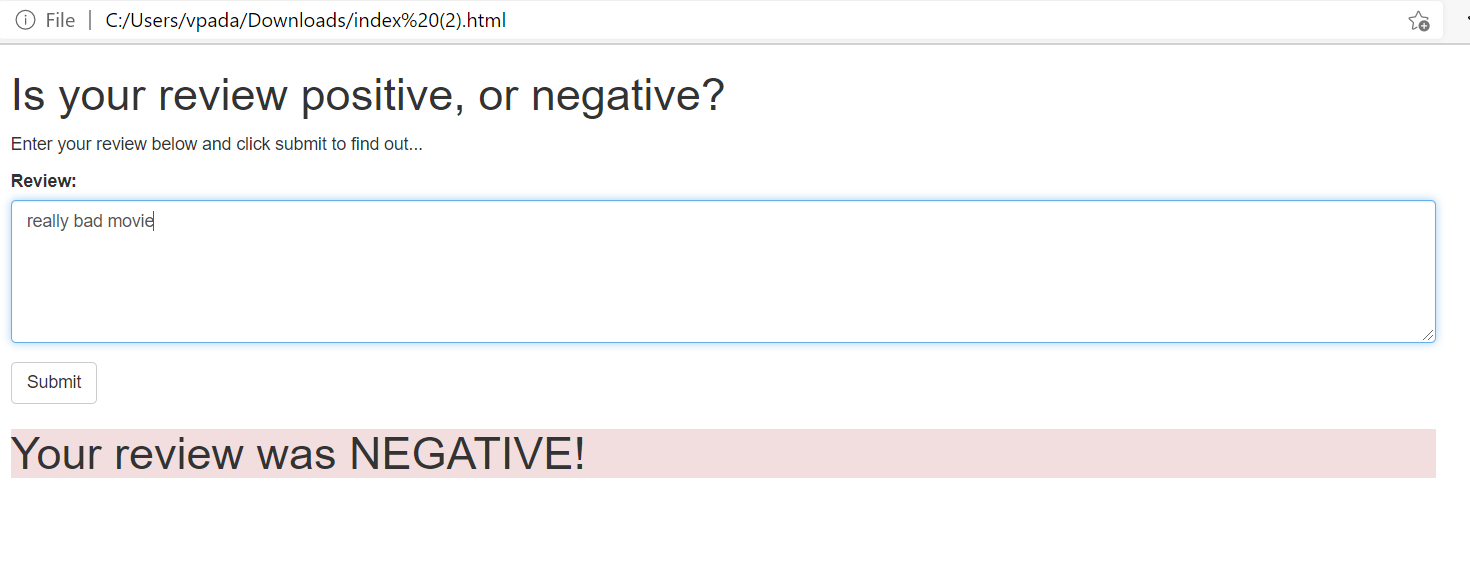

### Delete the endpoint

Remember to always shut down your endpoint if you are no longer using it. You are charged for the length of time that the endpoint is running so if you forget and leave it on you could end up with an unexpectedly large bill.

In [46]:
predictor.delete_endpoint()